본 ipynb 파일은 초기 제공 코드를 한국어 주석만 추가하고 분석한 파일로, 원본 파일이 더 자세히 적혀있고 의역이 있을 수 있다.   

원본 파일 : 
ch1_nb1_build_and_train_neural_network_from_scratch.ipynb

In [ ]:
# !pip install numpy    # Numpy 라이브러리가 이미 있을 경우 그대로 진행/ 만약 없을 경우 Pip install 커맨드로 설치 요망
import numpy as np      # 행렬곱 연산을 수행하기 때문에 Numpy array 사용. numpy 임포트. 
np.random.seed(0)      # random.seed() 함수는 난수 생성에 필요한 시드를 설정 https://yjs-program.tistory.com/177 참고

## At the Beginning: the Neuron

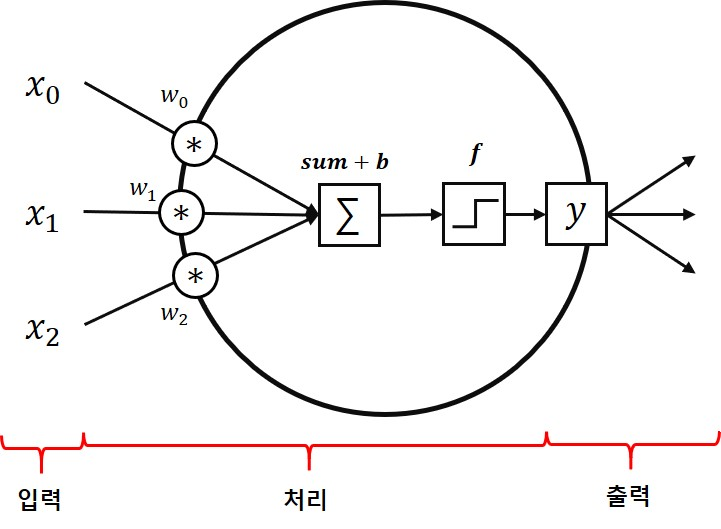

In [ ]:
class Neuron(object):
    """
    입력 벡터를 처리하여 activation function에 따라서 반환하는 인공 뉴런(Network가 아님)
    Args : 
        num_inputs(int): 입력 벡터 사이즈
        actviation_function(callable): Neuron 정의시 사용되는 활성화 함수
    Attributes :
        W(ndarray):각 입력 데이터의 Weight 값
        b(float): bias값 (Weight sum에 더해짐)
        activation_function (callable): 출력물 계산때 사용되는 activation function
    """

    def __init__(self, num_inputs, activation_function):
        super().__init__()

        # Randomly initializing the weight vector and the bias value (e.g., using a simplistic 
        # uniform distribution between -1 and 1):
        self.W = np.random.uniform(size=num_inputs, low=-1., high=1.)
        self.b = np.random.uniform(size=1, low=-1., high=1.)

        self.activation_function = activation_function

    def forward(self, x):
        """
        Forward the input signal through the neuron, returning its activation value.
        Args:
            x (ndarray): The input vector, of shape `(1, num_inputs)`
        Returns:
            activation (ndarray): The activation value, of shape `(1, layer_size)`.
        """
        z = np.dot(x, self.W) + self.b
        return self.activation_function(z)


This class represents a simple artificial neuron, able to receive a vector of input values, to merge and process them before returning an activation value. We will now demonstrate how this model can be used.

***Note:*** This class can also be found in [neuron.py](neuron.py).

First, we instantiate our neuron. Let us create a ***perceptron*** (c.f. Chapter 1) taking 2 input values and using the _step_ function for computing its *activation*. Its weights and bias values are randomly set.

In [ ]:
# Perceptron input size:
input_size = 3

# Step function (returns 0 if y <= 0, or 1 if y > 0):
step_function = lambda y: 0 if y <= 0 else 1

# Instantiating the perceptron:
perceptron = Neuron(num_inputs=input_size, activation_function=step_function)
print("Perceptron's random weights = {} , and random bias = {}".format(perceptron.W, perceptron.b))

Perceptron's random weights = [-0.25091976  0.90142861  0.46398788] , and random bias = [0.19731697]


We randomly generate a random input vector of 3 values (i.e. a column-vector of (shape = `(1, 3)`), to be fed to our neuron:

In [ ]:
x = np.random.rand(input_size).reshape(1, input_size)
print("Input vector : {}".format(x))

Input vector : [[0.15601864 0.15599452 0.05808361]]


We can now feed our perceptron with this input and display the corresponding activation. We invite our readers to try different inputs or edit the weights.

In [ ]:
y = perceptron.forward(x)
print("Perceptron's output value given `x` : {}".format(y))

Perceptron's output value given `x` : 1


With this `Neuron` class, we implemented the mathematical model for neurons proposed by early A.I. scientists.

## Layering Neurons Together

In the homonym section of Chapter 1, we presented how neurons can be organized into ***layers***. We introduced the following model, mathematically wrapping together the operations done by such a neural layer:

In [ ]:
class FullyConnectedLayer(object):
    """A simple fully-connected NN layer.
    Args:
        num_inputs (int): The input vector size / number of input values.
        layer_size (int): The output vector size / number of neurons in the layer.
        activation_function (callable): The activation function for this layer.
    Attributes:
        W (ndarray): The weight values for each input.
        b (ndarray): The bias value, added to the weighted sum.
        size (int): The layer size / number of neurons.
        activation_function (callable): The activation function computing the neuron's output.
        x (ndarray): The last provided input vector, stored for backpropagation.
        y (ndarray): The corresponding output, also stored for backpropagation.
        derivated_activation_function (callable): The corresponding derivated function for backpropagation.
        dL_dW (ndarray): The derivative of the loss, with respect to the weights W.
        dL_db (ndarray): The derivative of the loss, with respect to the bias b.
    """

    def __init__(self, num_inputs, layer_size, activation_function, derivated_activation_function=None):
        super().__init__()

        # Randomly initializing the weight vector and the bias value (using a normal distribution this time):
        self.W = np.random.standard_normal((num_inputs, layer_size))
        self.b = np.random.standard_normal(layer_size)
        self.size = layer_size

        self.activation_function = activation_function
        self.derivated_activation_function = derivated_activation_function
        self.x, self.y = None, None
        self.dL_dW, self.dL_db = None, None

    def forward(self, x):
        """
        Forward the input vector through the layer, returning its activation vector.
        Args:
            x (ndarray): The input vector, of shape `(batch_size, num_inputs)`
        Returns:
            activation (ndarray): The activation value, of shape `(batch_size, layer_size)`.
        """
        z = np.dot(x, self.W) + self.b
        self.y = self.activation_function(z)
        self.x = x  # (we store the input and output values for back-propagation)
        return self.y

    def backward(self, dL_dy):
        """
        Back-propagate the loss, computing all the derivatives, storing those w.r.t. the layer parameters,
        and returning the loss w.r.t. its inputs for further propagation.
        Args:
            dL_dy (ndarray): The loss derivative w.r.t. the layer's output (dL/dy = l'_{k+1}).
        Returns:
            dL_dx (ndarray): The loss derivative w.r.t. the layer's input (dL/dx).
        """
        dy_dz = self.derivated_activation_function(self.y)  # = f'
        dL_dz = (dL_dy * dy_dz) # dL/dz = dL/dy * dy/dz = l'_{k+1} * f'
        dz_dw = self.x.T
        dz_dx = self.W.T
        dz_db = np.ones(dL_dy.shape[0]) # dz/db = d(W.x + b)/db = 0 + db/db = "ones"-vector

        # Computing the derivatives with respect to the layer's parameters, and storing them for opt. optimization:
        self.dL_dW = np.dot(dz_dw, dL_dz)
        self.dL_db = np.dot(dz_db, dL_dz)

        # Computing the derivative with respect to the input, to be passed to the previous layers (their `dL_dy`):
        dL_dx = np.dot(dL_dz, dz_dx)
        return dL_dx

    def optimize(self, epsilon):
        """
        Optimize the layer's parameters, using the stored derivative values.
        Args:
            epsilon (float): The learning rate.
        """
        self.W -= epsilon * self.dL_dW
        self.b -= epsilon * self.dL_db

***Note:*** This class can also be found in [fully_connected_layer.py](fully_connected_layer.py). 

Once again, let us quickly show how this *layer* can be used to process input values, one by one or stacked together into ***batches***. We instantiate a layer of 3 neurons (so 3 output values), taking 2 input values and applying this time the ***ReLU*** (Rectified Linear Unit) function for the activations: 

In [ ]:
input_size    = 2
num_neurons   = 3
relu_function = lambda y: np.maximum(y, 0)

layer = FullyConnectedLayer(num_inputs=input_size, layer_size=num_neurons, activation_function=relu_function)

We randomly generate 2 random input vectors:

In [ ]:
x1 = np.random.uniform(-1, 1, 2).reshape(1, 2)
print("Input vector #1: {}".format(x1))

Input vector #1: [[-0.72101228 -0.4157107 ]]


In [ ]:
x2 = np.random.uniform(-1, 1, 2).reshape(1, 2)
print("Input vector #2: {}".format(x2))

Input vector #2: [[-0.26727631 -0.08786003]]


Our layer can either process them separetely:

In [ ]:
y1 = layer.forward(x1)
print("Layer's output value given `x1` : {}".format(y1))

Layer's output value given `x1` : [[0.         0.4593046  1.61941647]]


In [ ]:
y2 = layer.forward(x2)
print("Layer's output value given `x2` : {}".format(y2))

Layer's output value given `x2` : [[0.         0.73048436 1.05288999]]


... or together:

In [ ]:
x12 = np.concatenate((x1, x2))  # stack of input vectors, of shape `(2, 2)`
y12 = layer.forward(x12)
print("Layer's output value given `[x1, x2]` :\n{}".format(y12))

Layer's output value given `[x1, x2]` :
[[0.         0.4593046  1.61941647]
 [0.         0.73048436 1.05288999]]


## Implementing a Complete Neural Network

The purpose of neural layers is to be stacked together to form a ***neural network*** able to perform non-linear predictions.

Applying a ***gradient descent***, such a network can be trained to perform correct predictions (c.f. theory in Chapter 1). But for that, we need a ***loss*** function to evaluate the performance of the network (c.f. ***L2*** or ***cross-entropy*** losses introduced in Chapter 1), and we need to know how to *derive* all the operations performed by the network, to compute and propagate the gradients.

In this section, we will present how a simple fully-connected neural network can be built. Let us assume we want our network to use the *sigmoid* function for the activation. We need to implement that function _and_ its derivative:

In [ ]:
def sigmoid(x):             # sigmoid function
    y = 1 / (1 + np.exp(-x))
    return y


def derivated_sigmoid(y):   # sigmoid derivative function
    return y * (1 - y)

Suppose we want to build a neural network for classification. We would use the *L2* or *cross-entropy* loss previously introduced. We should also implement them, along their derivative:

In [ ]:
def loss_L2(pred, target):             # L2 loss function
    return np.sum(np.square(pred - target)) / pred.shape[0] # opt. we divide by the batch size


def derivated_loss_L2(pred, target):   # L2 derivative function
    return 2 * (pred - target)

In [ ]:
def binary_cross_entropy(pred, target):            # cross-entropy loss function
    return -np.mean(np.multiply(np.log(pred), target) + np.multiply(np.log(1 - pred), (1 - target)))


def derivated_binary_cross_entropy(pred, target):  # cross-entropy derivative function
    return (pred - target) / (pred * (1 - pred))

As described in the book, we should now connect everything together, building a class able to connect multiple neural layers together, able to to feed-forward data through these layers and back-propagate the loss' gradients for training:

In [ ]:
class SimpleNetwork(object):
    """A simple fully-connected NN.
    Args:
        num_inputs (int): The input vector size / number of input values.
        num_outputs (int): The output vector size.
        hidden_layers_sizes (list): A list of sizes for each hidden layer to add to the network
        activation_function (callable): The activation function for all the layers
        derivated_activation_function (callable): The derivated activation function
        loss_function (callable): The loss function to train this network
        derivated_loss_function (callable): The derivative of the loss function, for back-propagation
    Attributes:
        layers (list): The list of layers forming this simple network.
        loss_function (callable): The loss function to train this network.
        derivated_loss_function (callable): The derivative of the loss function, for back-propagation.
    """

    def __init__(self, num_inputs, num_outputs, hidden_layers_sizes=(64, 32),
                 activation_function=sigmoid, derivated_activation_function=derivated_sigmoid,
                 loss_function=loss_L2, derivated_loss_function=derivated_loss_L2):
        super().__init__()
        # We build the list of layers composing the network, according to the provided arguments:
        layer_sizes = [num_inputs, *hidden_layers_sizes, num_outputs]
        self.layers = [
            FullyConnectedLayer(layer_sizes[i], layer_sizes[i + 1], 
                                activation_function, derivated_activation_function)
            for i in range(len(layer_sizes) - 1)]

        self.loss_function = loss_function
        self.derivated_loss_function = derivated_loss_function

    def forward(self, x):
        """
        Forward the input vector through the layers, returning the output vector.
        Args:
            x (ndarray): The input vector, of shape `(batch_size, num_inputs)`.
        Returns:
            activation (ndarray): The output activation value, of shape `(batch_size, layer_size)`.
        """
        for layer in self.layers: # from the input layer to the output one
            x = layer.forward(x)
        return x

    def predict(self, x):
        """
        Compute the output corresponding to input `x`, and return the index of the largest 
        output value.
        Args:
            x (ndarray): The input vector, of shape `(1, num_inputs)`.
        Returns:
            best_class (int): The predicted class ID.
        """
        estimations = self.forward(x)
        best_class = np.argmax(estimations)
        return best_class

    def backward(self, dL_dy):
        """
        Back-propagate the loss hrough the layers (require `forward()` to be called before).
        Args:
            dL_dy (ndarray): The loss derivative w.r.t. the network's output (dL/dy).
        Returns:
            dL_dx (ndarray): The loss derivative w.r.t. the network's input (dL/dx).
        """
        for layer in reversed(self.layers): # from the output layer to the input one
            dL_dy = layer.backward(dL_dy)
        return dL_dy

    def optimize(self, epsilon):
        """
        Optimize the network parameters according to the stored gradients (require `backward()`
        to be called before).
        Args:
            epsilon (float): The learning rate.
        """
        for layer in self.layers:             # the order doesn't matter here
            layer.optimize(epsilon)

    def evaluate_accuracy(self, X_val, y_val):
        """
        Given a dataset and its ground-truth labels, evaluate the current accuracy of the network.
        Args:
            X_val (ndarray): The input validation dataset.
            y_val (ndarray): The corresponding ground-truth validation dataset.
        Returns:
            accuracy (float): The accuracy of the network 
                              (= number of correct predictions/dataset size).
        """
        num_corrects = 0
        for i in range(len(X_val)):
            pred_class = self.predict(X_val[i])
            if pred_class == y_val[i]:
                num_corrects += 1
        return num_corrects / len(X_val)

    def train(self, X_train, y_train, X_val=None, y_val=None, 
              batch_size=32, num_epochs=5, learning_rate=1e-3, print_frequency=20):
        """
        Given a dataset and its ground-truth labels, evaluate the current accuracy of the network.
        Args:
            X_train (ndarray): The input training dataset.
            y_train (ndarray): The corresponding ground-truth training dataset.
            X_val (ndarray): The input validation dataset.
            y_val (ndarray): The corresponding ground-truth validation dataset.
            batch_size (int): The mini-batch size.
            num_epochs (int): The number of training epochs i.e. iterations over the whole dataset.
            learning_rate (float): The learning rate to scale the derivatives.
            print_frequency (int): Frequency to print metrics (in epochs).
        Returns:
            losses (list): The list of training losses for each epoch.
            accuracies (list): The list of validation accuracy values for each epoch.
        """
        num_batches_per_epoch = len(X_train) // batch_size
        do_validation = X_val is not None and y_val is not None
        losses, accuracies = [], []
        for i in range(num_epochs): # for each training epoch
            epoch_loss = 0
            for b in range(num_batches_per_epoch):  # for each batch composing the dataset
                # Get batch:
                batch_index_begin = b * batch_size
                batch_index_end = batch_index_begin + batch_size
                x = X_train[batch_index_begin: batch_index_end]
                targets = y_train[batch_index_begin: batch_index_end]
                # Optimize on batch:
                predictions = y = self.forward(x)  # forward pass
                L = self.loss_function(predictions, targets)  # loss computation
                dL_dy = self.derivated_loss_function(predictions, targets)  # loss derivation
                self.backward(dL_dy)  # back-propagation pass
                self.optimize(learning_rate)  # optimization of the NN
                epoch_loss += L

            # Logging training loss and validation accuracy, to follow the training:
            epoch_loss /= num_batches_per_epoch
            losses.append(epoch_loss)
            if do_validation:
                accuracy = self.evaluate_accuracy(X_val, y_val)
                accuracies.append(accuracy)
            else:
                accuracy = np.NaN
            if i % print_frequency == 0 or i == (num_epochs - 1):
                print("Epoch {:4d}: training loss = {:.6f} | val accuracy = {:.2f}%".format(
                    i, epoch_loss, accuracy * 100))
        return losses, accuracies

***Note:*** This class can also be found in [simple_network.py](simple_network.py).


## Applying our Network to Classification

Using untrained perceptrons and layers on random inputs is however a bit dull. In this final section of the notebook, we instantiate and train our simple model to ***classify images of hand-written digits***. 


### Setting up the Task

For this task, we will use the the [MNIST dataset](http://yann.lecun.com/exdb/mnist) presented in the book[$^2$](#ref) (Yann LeCun and Corinna Cortes hold all copyrights for this dataset).

Before implementing a solution, we should prepare the data, loading the MNIST images for training and testing methods. For simplicity, we will use the Python module [`mnist`](https://github.com/datapythonista/mnist) developed by [Marc Garcia](https://github.com/datapythonista), and already installed in this chapter's directory (see [`./mnist/`](mnist/__init__.py)).

In [ ]:
%matplotlib inline
# !pip install matplotlib  # Uncomment and run if matplotlib is not installed yet.
import matplotlib          # We use this package to visualize some data and results
import matplotlib.pyplot as plt
import mnist

np.random.seed(42)

The `mnist` module makes it simple to load the training and testing data (images and their labels):

In [ ]:
X_train, y_train = mnist.train_images(), mnist.train_labels()
X_test,  y_test  = mnist.test_images(), mnist.test_labels()
num_classes = 10    # classes are the digits from 0 to 9

We can check the number and size of the training/testing samples:

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
X_test.shape

(10000, 28, 28)

i.e. we have 60,000 training samples and 10,000 testing one, with each sample an image of $28 \times 28$ pixels.

We can have a look at the data, for instance using `matplotlib`:

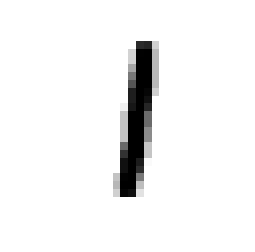

In [ ]:
img_idx = np.random.randint(0, X_test.shape[0])
plt.imshow(X_test[img_idx], cmap=matplotlib.cm.binary)
plt.axis("off")
plt.show()

In [ ]:
y_test[img_idx]

1

As we can see, our images match their ground-truth label, which is good news!

However, as our network only accepts column vectors, we need to _flatten_ the images into 1D vectors, i.e. vectors of shape `(1, 784)` (since $28 \times 28 = 784$):

In [ ]:
X_train, X_test = X_train.reshape(-1, 28 * 28), X_test.reshape(-1, 28 * 28)

Also, let us have a look at our pixel values:

In [ ]:
print("Pixel values between {} and {}".format(X_train.min(), X_train.max()))

Pixel values between 0 and 255


Those are normal integer values for images with 8 bits per channel (`uint8`)... These values may be however too big for some of our operations. For instance, given a too big input value, our sigmoid may return `nan` ("_not a number_") because of the exponential function it uses, which may "overflow" with a large input value.

It is thus customary to *normalize* the input data, i.e. to scale the values between 0 and 1 (or -1 and 1):

In [ ]:
X_train, X_test = X_train / 255., X_test / 255.
print("Normalized pixel values between {} and {}".format(X_train.min(), X_train.max()))

Normalized pixel values between 0.0 and 1.0


Finally, to compute the loss, we need to ***one-hot*** the labels, e.g. converting the label `4` into `[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]`:

In [ ]:
y_train = np.eye(num_classes)[y_train]

### Instantiating the Network

Time to prepare the classifier itself. Let us use our `SimpleNetwork` class and instantiate a network with 2 hidden layers, taking a flattened image as input and returning a 10-value vector representing its belief the image belongs to each of the class (the highter the value,the stronger the belief): 

In [ ]:
mnist_classifier = SimpleNetwork(num_inputs=X_train.shape[1], 
                                 num_outputs=num_classes, hidden_layers_sizes=[64, 32])

We can now check how our network performs (computing its *loss* over the training set, and its *accuracy* over the test set):

In [ ]:
predictions = mnist_classifier.forward(X_train)                         # forward pass
loss_untrained = mnist_classifier.loss_function(predictions, y_train)   # loss computation

accuracy_untrained = mnist_classifier.evaluate_accuracy(X_test, y_test)  # Accuracy
print("Untrained : training loss = {:.6f} | val accuracy = {:.2f}%".format(
    loss_untrained, accuracy_untrained * 100))

Untrained : training loss = 4.436700 | val accuracy = 12.19%


... This is a really poor performance... But as we know from the book, this is to be expected: we have yet to train our network

### Teaching our Network to Classify

This is where things finally get interesting. As the whole training procedure is already explained and implemented, we simply have to launch it (note: the training takes minutes/hours):

In [ ]:
losses, accuracies = mnist_classifier.train(X_train, y_train, X_test, y_test, 
                                            batch_size=30, num_epochs=500)
# note: Reduce the batch size and/or number of epochs if your computer can't 
#       handle the computations / takes too long.
#       Remember, numpy also uses the CPU, not GPUs as modern Deep Learning 
#       libraries do, hence the lack of computational performance here.

Epoch    0: training loss = 1.096978 | val accuracy = 19.10%
Epoch   20: training loss = 0.252953 | val accuracy = 84.89%
Epoch   40: training loss = 0.177532 | val accuracy = 88.92%
Epoch   60: training loss = 0.146596 | val accuracy = 90.50%
Epoch   80: training loss = 0.128075 | val accuracy = 91.29%
Epoch  100: training loss = 0.114770 | val accuracy = 92.01%
Epoch  120: training loss = 0.104585 | val accuracy = 92.39%
Epoch  140: training loss = 0.096663 | val accuracy = 92.74%
Epoch  160: training loss = 0.090176 | val accuracy = 93.06%
Epoch  180: training loss = 0.084631 | val accuracy = 93.22%
Epoch  200: training loss = 0.079820 | val accuracy = 93.46%
Epoch  220: training loss = 0.075625 | val accuracy = 93.66%
Epoch  240: training loss = 0.071941 | val accuracy = 93.72%
Epoch  260: training loss = 0.068681 | val accuracy = 93.93%
Epoch  280: training loss = 0.065795 | val accuracy = 94.12%
Epoch  300: training loss = 0.063194 | val accuracy = 94.28%
Epoch  320: training los

Almost **95%** of accuracy! This is much better. Congratulations, we implemented and trained our first neural network classifier!

Finally, we can plot the evolution of the loss and accuracy during the training, to better visualize the evolution:

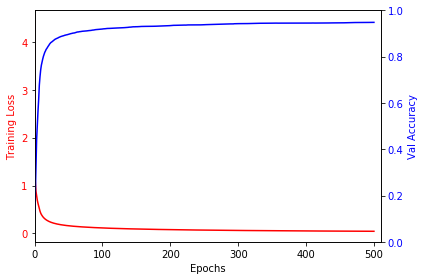

In [ ]:
losses, accuracies = [loss_untrained] + losses, [accuracy_untrained] + accuracies
fig, ax_loss = plt.subplots()

color = 'red'
ax_loss.set_xlim([0, 510])
ax_loss.set_xlabel('Epochs')
ax_loss.set_ylabel('Training Loss', color=color)
ax_loss.plot(losses, color=color)
ax_loss.tick_params(axis='y', labelcolor=color)

ax_acc = ax_loss.twinx()  # instantiate a second axes that shares the same x-axis
color = 'blue'
ax_acc.set_xlim([0, 510])
ax_acc.set_ylim([0, 1])
ax_acc.set_ylabel('Val Accuracy', color=color)
ax_acc.plot(accuracies, color=color)
ax_acc.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

As we can see, our network *converged* quite fast, though the accuracy slowly kept increasing. It looks even like the accuracy could still go up a bit with some further training iterations... We leave it to our readers to check. 

Before concluding this notebook, let us verify how our network is now performing on our random test image:

In [ ]:
# We use `np.expand_dims(x, 0)` to simulate a batch (transforming the image shape
# from (784,) to (1, 784)):
predicted_class = mnist_classifier.predict(np.expand_dims(X_test[img_idx], 0))
print('Predicted class: {}; Correct class: {}'.format(predicted_class, y_test[img_idx]))

Predicted class: 1; Correct class: 1


## Conclusion

Through this first notebook, we illustrated the main notions of Chapter 1, starting with the implementation of a single artificial neuron and ending up with a network compose of several thousand neurons, able to classify digits with a decent accuracy.

Training this network was however a slow process. In the next chapter and related notebooks, we will finally get started with TensorFlow 2 and Keras, to easily scale up our use-cases!

<a id="ref"></a>
#### References

1. Rosenblatt, F., 1958. The perceptron: a probabilistic model for information storage and organization in the brain. Psychological review 65, 386.
2. LeCun, Y., Cortes, C., Burges, C., 2010. MNIST handwritten digit database. AT&T Labs [Online]. Available: http://yann.lecun.com/exdb/mnist 2, 18.